In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from PIL import Image
from torchvision import transforms as tfs
import random
import pandas as pd 
from datetime import datetime
from sklearn.neighbors import LocalOutlierFactor as LOF
from sklearn import metrics
from torchvision.transforms import Resize 
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
## Preprocess Spectra
yxqdata = scio.loadmat('./CAO.mat')
X_training_normal= yxqdata['X_training_normal']/6000
X_training = yxqdata['X_training']/6000
X_test = yxqdata['X_test']/6000
X_pre = yxqdata['X_pre']/6000

X_training_normal[X_training_normal<0]=0
X_training[X_training<0]=0
X_test[X_test<0]=0
X_pre[X_pre<0]=0

Y_training_normal = (yxqdata['Y_training_normal']).squeeze()
Y_training = (yxqdata['Y_training']).squeeze()
Y_test = (yxqdata['Y_test']).squeeze()
Y_pre = (yxqdata['Y_pre']).squeeze()

#resize
def data_resize(data,a,b):  
    data_1=np.moveaxis(data,-1, 0)  
    data_1 = torch.from_numpy(data_1.astype(np.float32)).unsqueeze(0) 
    torch_resize = Resize([a,b])  
    data_resize = torch_resize(data_1) 
    data_resize=data_resize.squeeze(0)  
    data_resize = data_resize.numpy() 
    data_resize=np.moveaxis(data_resize, 0, -1)  

    return data_resize

## 
X_training_normal=data_resize(X_training_normal,80,120)
X_training=data_resize(X_training,80,120)
X_test=data_resize(X_test,80,120)
X_pre=data_resize(X_pre,80,120)

In [3]:
#define Dataset
class yxqDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.labels = labels
        self.imgs = data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.imgs[:,:,idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

data_tf = transforms.ToTensor()  
trainset_normal = yxqDataset(X_training_normal, Y_training_normal, transform=data_tf)            
train_normal_loader = DataLoader(trainset_normal, batch_size=16,shuffle=True)

In [4]:
#define CAE
class ConvAutoencoder(nn.Module):
    def __init__(self):
            super(ConvAutoencoder, self).__init__()
            #encoder
            self.encoder1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU())                                          
            self.max_pool1=nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)  
            self.encoder2 = nn.Sequential(                       
            nn.Conv2d(16, 32, kernel_size=3,stride=1, padding=0), 
            nn.ReLU())
            self.max_pool2=nn.MaxPool2d(kernel_size=2,stride=2, return_indices=True)  
           
            self.encoder_fc = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=32*19*29, out_features=120),
            nn.Linear(in_features=120, out_features=32))
         
            #dencoder
            self.dencoder_fc = nn.Sequential(   
            nn.Linear(in_features=32, out_features=120),
            nn.Linear(in_features=120, out_features=32*19*29),
            nn.Unflatten(dim=1,unflattened_size=(32, 19, 29)))
        
            self.maxunpool1=nn.MaxUnpool2d(kernel_size=2,stride=2)
            self.dencoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=0),
            nn.ReLU())
            self.maxunpool2=nn.MaxUnpool2d(kernel_size=2,stride=2)
            self.dencoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh ())  
            
    def forward(self, x):
            x = self.encoder1(x)
            x,indices1 = self.max_pool1(x)
            x = self.encoder2(x)
            x,indices2 = self.max_pool2(x)
            encoder = self.encoder_fc(x)
            x = self.dencoder_fc(encoder)
            x = self.maxunpool1(x,indices2)
            x = self.dencoder1(x)
            x = self.maxunpool2(x,indices1)
            dencoder = self.dencoder2(x)
            return encoder,dencoder

In [6]:
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
df = pd.DataFrame(columns=['epoch','train_loss'])
df.to_csv('../result/CAO/loss/CAO_loss1.csv',index=False)

Epoch 1/350, Training Loss: 0.004123, 
Epoch 2/350, Training Loss: 0.003203, 
Epoch 3/350, Training Loss: 0.002601, 
Epoch 4/350, Training Loss: 0.002176, 
Epoch 5/350, Training Loss: 0.001856, 
Epoch 6/350, Training Loss: 0.001603, 
Epoch 7/350, Training Loss: 0.001405, 
Epoch 8/350, Training Loss: 0.001251, 
Epoch 9/350, Training Loss: 0.001126, 
Epoch 10/350, Training Loss: 0.001025, 
Epoch 11/350, Training Loss: 0.000941, 
Epoch 12/350, Training Loss: 0.000870, 
Epoch 13/350, Training Loss: 0.000809, 
Epoch 14/350, Training Loss: 0.000757, 
Epoch 15/350, Training Loss: 0.000711, 
Epoch 16/350, Training Loss: 0.000670, 
Epoch 17/350, Training Loss: 0.000634, 
Epoch 18/350, Training Loss: 0.000602, 
Epoch 19/350, Training Loss: 0.000572, 
Epoch 20/350, Training Loss: 0.000546, 
Epoch 21/350, Training Loss: 0.000522, 
Epoch 22/350, Training Loss: 0.000500, 
Epoch 23/350, Training Loss: 0.000479, 
Epoch 24/350, Training Loss: 0.000461, 
Epoch 25/350, Training Loss: 0.000444, 
Epoch 26/

Epoch 204/350, Training Loss: 0.000060, 
Epoch 205/350, Training Loss: 0.000060, 
Epoch 206/350, Training Loss: 0.000060, 
Epoch 207/350, Training Loss: 0.000060, 
Epoch 208/350, Training Loss: 0.000059, 
Epoch 209/350, Training Loss: 0.000059, 
Epoch 210/350, Training Loss: 0.000059, 
Epoch 211/350, Training Loss: 0.000059, 
Epoch 212/350, Training Loss: 0.000058, 
Epoch 213/350, Training Loss: 0.000058, 
Epoch 214/350, Training Loss: 0.000058, 
Epoch 215/350, Training Loss: 0.000058, 
Epoch 216/350, Training Loss: 0.000057, 
Epoch 217/350, Training Loss: 0.000057, 
Epoch 218/350, Training Loss: 0.000057, 
Epoch 219/350, Training Loss: 0.000057, 
Epoch 220/350, Training Loss: 0.000056, 
Epoch 221/350, Training Loss: 0.000056, 
Epoch 222/350, Training Loss: 0.000056, 
Epoch 223/350, Training Loss: 0.000056, 
Epoch 224/350, Training Loss: 0.000055, 
Epoch 225/350, Training Loss: 0.000055, 
Epoch 226/350, Training Loss: 0.000055, 
Epoch 227/350, Training Loss: 0.000055, 
Epoch 228/350, T

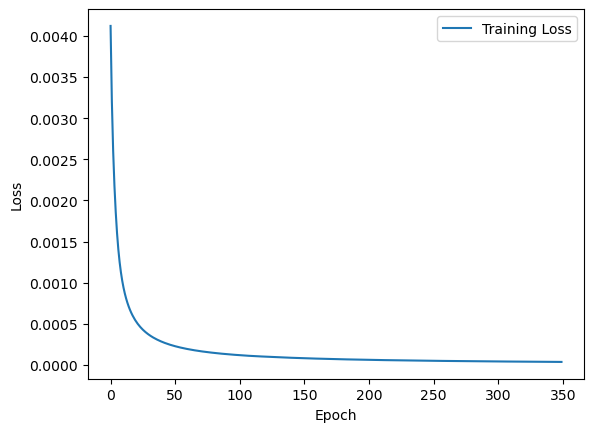

In [6]:
train_losses=[] 
list=[]
train_num = 0
train_loss_epoch=0
num_epochs = 350 
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train() 
    for data in train_normal_loader:
        img, _ = data
        img=img.to(torch.float32)
        train_recon,train_recon2 = model(img)   
        train_recon2=train_recon2.to(torch.float32)
        loss = criterion(train_recon2, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item() * img.size(0)
        train_num = train_num + img.size(0)
        train_loss = train_loss_epoch / train_num
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Training Loss: {train_loss:.6f}, ')
    list = [epoch+1,train_loss]
    data = pd.DataFrame([list])
    data.to_csv('../result/CAO/loss/CAO_loss1.csv',mode='a',header=False,index=False)  
    train_losses.append(train_loss)

plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

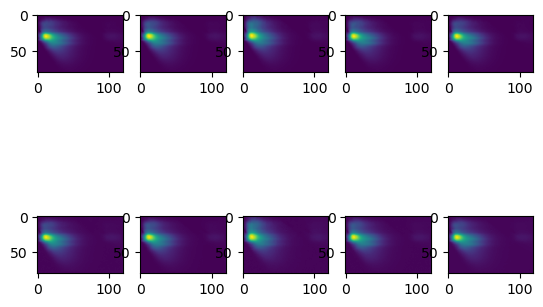

In [7]:
n=5
fig = plt.figure()
for i in range(n):
    plt.subplot(2,n,i+1) 
    imgs = trainset_normal[i][0].unsqueeze(0) 
    plt.imshow(imgs.squeeze().numpy())  
    with torch.no_grad():
        imgs=imgs.to(torch.float32)
        output_1, output_2 = model(imgs)  
        plt.subplot(2, n, i + 1 + n)        
        output_2=output_2.view(1,80,120) 
        plt.imshow(output_2.squeeze().numpy()) 

  

In [8]:
#torch.save(model.state_dict(), './model_CAO_1'))

In [9]:
#load model
model.load_state_dict(torch.load('./model_CAO.pt'))

# Dataloader
training_normal_loader = DataLoader(trainset_normal,shuffle=False) 
trainset = yxqDataset(X_training, Y_training, transform=data_tf)                
training_loader = DataLoader(trainset,shuffle=False) 
testset = yxqDataset(X_test, Y_test, transform=data_tf)              
test_loader = DataLoader(testset,shuffle=False) 
preset = yxqDataset(X_pre, Y_pre, transform=data_tf)                
pre_loader = DataLoader(preset,shuffle=False) 

In [10]:
def CAE(loader):
    recon_list=[]
    recon2_list=[]
    loss_list=[]
    labels_list=[]
    model.eval()  
    for i, data in enumerate(loader):
        img, labels = data
        img=img.to(torch.float32)
        recon,recon2 = model(img)
        loss = criterion(recon2, img)
        loss_list.append(loss.item())
        recon_list.extend(recon.to('cpu').detach().numpy()) 
        recon2_list.extend(recon2.to('cpu').detach().numpy())
        labels_list.extend(labels.to('cpu').numpy())
    
    labels=np.array(labels_list) 
    loss=np.array(loss_list)
    recon=np.array(recon_list)
    recon2_list = torch.tensor(recon2_list) 
    k=np.size(recon2_list,0) 
    recon2_list=recon2_list.view(1*k,80,120)
    recon2_list =recon2_list.detach().numpy()
    
    return labels,loss,recon,recon2_list

In [11]:
#reconstruction loss and hide layer data on training normal set
training_normal_label,training_normal_loss,training_normal_recon,training_normal_recon2=CAE(training_normal_loader)

<AxesSubplot:>

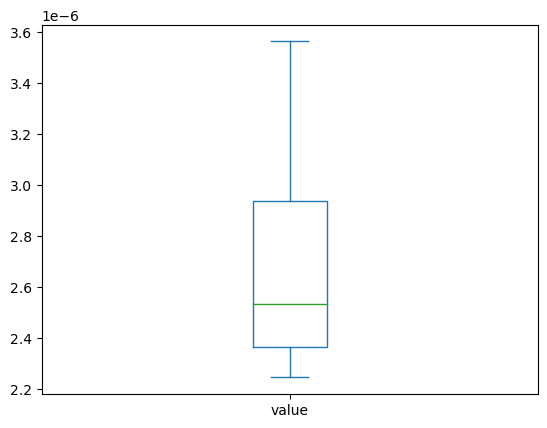

In [12]:
def box_outlier(df,label):  
    Q1 = df.quantile(q=0.25)  
    Q3 = df.quantile(q=0.75)  
    
    up_whisker=Q3+1.5*(Q3-Q1) 
    low_whisker=Q1-1.5*(Q3 - Q1) 
    
    kk = df[(df > up_whisker) | (df < low_whisker)]
    data = pd.DataFrame({'id': kk.index, 'Outlier': kk,'label':label[kk.index]})

    return data,Q1,Q3,up_whisker,low_whisker,kk,kk.index

df = pd.DataFrame(training_normal_loss, columns= ['value'])
df= df.iloc[:,0]  
result,Q1,Q3,up_whisker,low_whisker,kk,kk.index = box_outlier(df,training_normal_label)

import matplotlib.pyplot as plt
fig,axes = plt.subplots()
df.plot(kind='box',ax=axes)

In [13]:
#LOF model
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF(contamination = 0.01) 
clf.fit(training_normal_recon)
training_normal_pred = clf.predict(training_normal_recon)  

print("confusion_matrix:\n", metrics.confusion_matrix(training_normal_label,training_normal_pred))

confusion_matrix:
 [[125]]


In [14]:
# obtained the reconstruction loss and hide layer data on training, test and prediction sets
training_label,training_loss,training_recon,training_recon2=CAE(training_loader)
test_label,test_loss,test_recon,test_recon2=CAE(test_loader)
pre_label,pre_loss,pre_recon,pre_recon2=CAE(pre_loader)

In [15]:
#define the OCC_CAE classify based on box and lof 
#define the OCC_CAE classify based on box and lof 
def OCC_CAE_class(label,loss,recon,up_whisker,training_normal_recon):
    loss_index_abnormal_1=np.flatnonzero(loss>up_whisker)
    k=len(label) 
    Boxplot_prelabel = np.zeros(k)
    Boxplot_prelabel[loss_index_abnormal_1] = 1
    
    clf = LOF(contamination = 0.01) 
    clf.fit(training_normal_recon)
    LOF_prelabel = clf.predict(recon) 
    
    OC_CAE_prelabel=Boxplot_prelabel+LOF_prelabel
    OC_CAE_prelabel_abnormal_index=np.flatnonzero(OC_CAE_prelabel > 0 )
    OC_CAE_prelabel_normal_index=np.flatnonzero(OC_CAE_prelabel == 0 )
    
    OC_CAE_prelabel[OC_CAE_prelabel_abnormal_index]=1
    OC_CAE_prelabel[OC_CAE_prelabel_normal_index]=0
    
    return label,Boxplot_prelabel,LOF_prelabel,OC_CAE_prelabel

In [16]:
label_training,Boxplot_training,LOF_training,OC_CAE_training=OCC_CAE_class(training_label,training_loss,training_recon,up_whisker,training_normal_recon)
print("Training Set Classification:")
print("Boxplot confusion_matrix:\n", metrics.confusion_matrix(label_training,Boxplot_training))
print("LOF confusion_matrix:\n", metrics.confusion_matrix(label_training,LOF_training))
print("OC_CAE confusion_matrix:\n", metrics.confusion_matrix(label_training,OC_CAE_training))
tp, fn, fp, tn = metrics.confusion_matrix(label_training,OC_CAE_training).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(label_training,OC_CAE_training))
print('Specificity（特异性）：',Specificity)

Training Set Classification:
Boxplot confusion_matrix:
 [[25  0]
 [ 0 72]]
LOF confusion_matrix:
 [[25  0]
 [29 43]]
OC_CAE confusion_matrix:
 [[25  0]
 [ 0 72]]
tp: 25, fn: 0, fp: 0, tn: 72
Accuracy: 1.0
Specificity（特异性）： 1.0


In [17]:
label_test,Boxplot_test,LOF_test,OC_CAE_test=OCC_CAE_class(test_label,test_loss,test_recon,up_whisker,training_normal_recon)
print("Prediction Set Classification:")
print("Boxplot confusion_matrix:\n", metrics.confusion_matrix(label_test,Boxplot_test))
print("LOF confusion_matrix:\n", metrics.confusion_matrix(label_test,LOF_test))
print("OC_CAE confusion_matrix:\n", metrics.confusion_matrix(label_test,OC_CAE_test))
tp, fn, fp, tn = metrics.confusion_matrix(label_test,OC_CAE_test).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(label_test,OC_CAE_test))
print('Specificity（特异性）：',Specificity)

Prediction Set Classification:
Boxplot confusion_matrix:
 [[ 6  2]
 [ 0 24]]
LOF confusion_matrix:
 [[ 7  1]
 [ 9 15]]
OC_CAE confusion_matrix:
 [[ 6  2]
 [ 0 24]]
tp: 6, fn: 2, fp: 0, tn: 24
Accuracy: 0.9375
Specificity（特异性）： 1.0


In [18]:
label_pre,Boxplot_pre,LOF_pre,OC_CAE_pre=OCC_CAE_class(pre_label,pre_loss,pre_recon,up_whisker,training_normal_recon)
print("Prediction Set Classification:")
print("Boxplot confusion_matrix:\n", metrics.confusion_matrix(label_pre,Boxplot_pre))
print("LOF confusion_matrix:\n", metrics.confusion_matrix(label_pre,LOF_pre))
print("OC_CAE confusion_matrix:\n", metrics.confusion_matrix(label_pre,OC_CAE_pre))
tp, fn, fp, tn = metrics.confusion_matrix(label_pre,OC_CAE_pre).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(label_pre,OC_CAE_pre))
print('Specificity（特异性）：',Specificity)

Prediction Set Classification:
Boxplot confusion_matrix:
 [[3 0]
 [0 9]]
LOF confusion_matrix:
 [[3 0]
 [4 5]]
OC_CAE confusion_matrix:
 [[3 0]
 [0 9]]
tp: 3, fn: 0, fp: 0, tn: 9
Accuracy: 1.0
Specificity（特异性）： 1.0


In [19]:
# reshape data
k_training_normal=np.size(X_training_normal,2)
X_training_normal_reshape=X_training_normal.transpose(2, 0, 1) 
X_training_normal_reshape=X_training_normal_reshape.reshape(k_training_normal,9600)  

k_training=np.size(X_training,2)
X_training_reshape=X_training.transpose(2, 0, 1) 
X_training_reshape=X_training_reshape.reshape(k_training,9600) 

k_test=np.size(X_test,2)
X_test_reshape=X_test.transpose(2, 0, 1) 
X_test_reshape=X_test_reshape.reshape(k_test,9600)  
print(X_test_reshape.shape)

k_pre=np.size(X_pre,2)
X_pre_reshape=X_pre.transpose(2, 0, 1) 
X_pre_reshape=X_pre_reshape.reshape(k_pre,9600)  

(32, 9600)


In [20]:
#Boxplot
def dist(X):
    sample=np.size(X,0)
    dist_list=[]
    for i in range(sample):
        data=X[i,:]
        sum=0
        for j in range(9600):
            sum+=data[j]**2
            dist = np.sqrt(sum)
        dist_list.append(dist.item())
    dist_list =torch.tensor(dist_list)
    return dist_list

##
dist_training_normal=dist(X_training_normal_reshape)
dist_training=dist(X_training_reshape)
dist_test=dist(X_test_reshape)
dist_pre=dist(X_pre_reshape)

##
df = pd.DataFrame(dist_training_normal, columns= ['value'])
df= df.iloc[:,0]  
result,Q1,Q3,up_whisker,low_whisker,kk,kk.index = box_outlier(df,Y_training_normal)

##
def dist_boxclass(dist,label,up_whisker,low_whisker):
    dist_index_abnormal_1=np.flatnonzero(dist<low_whisker) 
    dist_index_abnormal_2=np.flatnonzero(dist>up_whisker)  
    k=len(label)
    dist_prelabel = np.zeros(k)
    dist_prelabel[dist_index_abnormal_1] = 1
    dist_prelabel[dist_index_abnormal_2] = 1
    return dist_prelabel

##
dist_trainlabel=dist_boxclass(dist_training,Y_training,up_whisker,low_whisker)
print('Classification results of Training Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_training,dist_trainlabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_training,dist_trainlabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_training,dist_trainlabel))
print('Specificity（特异性）：',Specificity)
print('')

dist_testlabel=dist_boxclass(dist_test,Y_test,up_whisker,low_whisker)
print('Classification results of Test Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_test,dist_testlabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_test,dist_testlabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_test,dist_testlabel))
print('Specificity（特异性）：',Specificity)
print('')

dist_prelabel=dist_boxclass(dist_pre,Y_pre,up_whisker,low_whisker)
print('Classification results of Prediction Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_pre,dist_prelabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_pre,dist_prelabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_pre,dist_prelabel))
print('Specificity（特异性）：',Specificity)


Classification results of Training Set:
confusion_matrix:
 [[20  5]
 [69  3]]
tp: 20, fn: 5, fp: 69, tn: 3
Accuracy: 0.23711340206185566
Specificity（特异性）： 0.041666666666666664

Classification results of Test Set:
confusion_matrix:
 [[ 8  0]
 [23  1]]
tp: 8, fn: 0, fp: 23, tn: 1
Accuracy: 0.28125
Specificity（特异性）： 0.041666666666666664

Classification results of Prediction Set:
confusion_matrix:
 [[3 0]
 [7 2]]
tp: 3, fn: 0, fp: 7, tn: 2
Accuracy: 0.4166666666666667
Specificity（特异性）： 0.2222222222222222


In [21]:
#LOF algorithm
from pyod.models.lof import LOF
clf_name = 'LOF'
clf = LOF(contamination = 0.01) 
clf.fit(X_training_normal_reshape)

lof_trainlabel = clf.predict(X_training_reshape)
print('Classification results of Training Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_training,lof_trainlabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_training,lof_trainlabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_training,lof_trainlabel))
print('Specificity（特异性）：',Specificity)
print('')

lof_testlabel = clf.predict(X_test_reshape)
print('Classification results of Test Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_test,lof_testlabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_test,lof_testlabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_test,lof_testlabel))
print('Specificity（特异性）：',Specificity)
print('')

lof_prelabel = clf.predict(X_pre_reshape)
print('Classification results of Prediction Set:')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_pre,lof_prelabel))
tp, fn, fp, tn = metrics.confusion_matrix(Y_pre,lof_prelabel).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_pre,lof_prelabel))
print('Specificity（特异性）：',Specificity)

Classification results of Training Set:
confusion_matrix:
 [[25  0]
 [23 49]]
tp: 25, fn: 0, fp: 23, tn: 49
Accuracy: 0.7628865979381443
Specificity（特异性）： 0.6805555555555556

Classification results of Test Set:
confusion_matrix:
 [[ 7  1]
 [ 8 16]]
tp: 7, fn: 1, fp: 8, tn: 16
Accuracy: 0.71875
Specificity（特异性）： 0.6666666666666666

Classification results of Prediction Set:
confusion_matrix:
 [[3 0]
 [3 6]]
tp: 3, fn: 0, fp: 3, tn: 6
Accuracy: 0.75
Specificity（特异性）： 0.6666666666666666


In [22]:
#OC_SVM
gammas = np.logspace(-4, 2, 7)
nus = np.linspace(0.01, 0.99, 99)
from sklearn.svm import OneClassSVM
##  grid search start
best_score=0
clf = OneClassSVM()
results = []
results_2=[]
for gamma in gammas:
    for nu in nus:
        clf.set_params(kernel='rbf',gamma=gamma, nu=nu)
        clf.fit(X_training_normal_reshape)
      
        y_training = clf.predict(X_training_reshape)
        y_training_normal=np.flatnonzero(y_training == 1)
        y_training_abnormal=np.flatnonzero(y_training == -1)
        y_training[y_training_normal]=0
        y_training[y_training_abnormal]=1
        y_training_score=metrics.accuracy_score(Y_training, y_training)
      
        y_test = clf.predict(X_test_reshape)
        y_test_normal=np.flatnonzero(y_test  == 1)
        y_test_abnormal=np.flatnonzero(y_test  == -1)
        y_test[y_test_normal]=0
        y_test[y_test_abnormal]=1
        y_test_score=metrics.accuracy_score(Y_test, y_test)
      
        y_pre = clf.predict(X_pre_reshape)
        y_pre_normal=np.flatnonzero(y_pre == 1)
        y_pre_abnormal=np.flatnonzero(y_pre == -1)
        y_pre[y_pre_normal]=0
        y_pre[y_pre_abnormal]=1
        y_pre_score=metrics.accuracy_score(Y_pre, y_pre)
        score=y_training_score+y_test_score+y_pre_score
        if score > best_score:#find the optimized parameter;
            best_score = score
            best_parameters = {'gamma':gamma,'nu':nu}
            score_results={'Training_score':y_training_score,'Test_score':y_pre_score}
#  grid search end
print("Best score:{:.2f}".format(best_score))
print("Score:{}".format(score_results))
print("Best parameters:{}".format(best_parameters))

###
model_1 = OneClassSVM(kernel='rbf', nu=0.06, gamma=1)
model_1.fit(X_training_normal_reshape)

##
def OneSVM_class(X_reshape):
    OneSVM_normal = model_1.predict(X_reshape)   
    OneSVM_normal_index=np.flatnonzero(OneSVM_normal == 1)
    OneSVM_abnormal_index=np.flatnonzero(OneSVM_normal == -1)
    OneSVM_normal[OneSVM_normal_index]=0
    OneSVM_normal[OneSVM_abnormal_index]=1
    return OneSVM_normal

##
OneSVM_training_label=OneSVM_class(X_training_reshape)
print('Classification results of Training Set')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_training,OneSVM_training_label))
tp, fn, fp, tn = metrics.confusion_matrix(Y_training,OneSVM_training_label).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_training,OneSVM_training_label))
print('Specificity（特异性）：',Specificity)
print('')

OneSVM_test_label=OneSVM_class(X_test_reshape)
print('Classification results of Test Set')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_test,OneSVM_test_label))
tp, fn, fp, tn = metrics.confusion_matrix(Y_test,OneSVM_test_label).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_test,OneSVM_test_label))
print('Specificity（特异性）：',Specificity)


OneSVM_pre_label=OneSVM_class(X_pre_reshape)
print('Classification results of Prediction Set')
print("confusion_matrix:\n", metrics.confusion_matrix(Y_pre,OneSVM_pre_label))
tp, fn, fp, tn = metrics.confusion_matrix(Y_pre,OneSVM_pre_label).ravel()
print("tp: {}, fn: {}, fp: {}, tn: {}".format(tp, fn, fp, tn)) 
Specificity = tn / (tn + fp)  
print('Accuracy:',metrics.accuracy_score(Y_pre,OneSVM_pre_label))
print('Specificity（特异性）：',Specificity)

Best score:2.78
Score:{'Training_score': 0.9381443298969072, 'Test_score': 1.0}
Best parameters:{'gamma': 1.0, 'nu': 0.060000000000000005}
Classification results of Training Set
confusion_matrix:
 [[22  3]
 [ 3 69]]
tp: 22, fn: 3, fp: 3, tn: 69
Accuracy: 0.9381443298969072
Specificity（特异性）： 0.9583333333333334

Classification results of Test Set
confusion_matrix:
 [[ 4  4]
 [ 1 23]]
tp: 4, fn: 4, fp: 1, tn: 23
Accuracy: 0.84375
Specificity（特异性）： 0.9583333333333334
Classification results of Prediction Set
confusion_matrix:
 [[3 0]
 [0 9]]
tp: 3, fn: 0, fp: 0, tn: 9
Accuracy: 1.0
Specificity（特异性）： 1.0
